# Monkey-patch mpi4py to avoid needing an actual MPI runtime
import sys, types
fake_mpi = types.ModuleType("mpi4py")
fake_mpi.MPI = None
sys.modules["mpi4py"] = fake_mpi
sys.modules["mpi4py.MPI"] = None

# Install required packages if not already installed
import subprocess
required_packages = ["pyparsvd==0.0.4", "memory_profiler", "netcdf4", "h5py"]
for pkg in required_packages:
    subprocess.call([sys.executable, "-m", "pip", "install", "--quiet", pkg])


In [1]:
# --- MPI Dummy Patch for serial PyParSVD ---
import sys, types

# Create a dummy mpi4py.MPI module to satisfy ParSVD_Base initialization
mpi_mod = types.ModuleType("mpi4py.MPI")
class CommDummy:
    def Get_rank(self): return 0
    def Get_size(self): return 1
mpi_mod.COMM_WORLD = CommDummy()
# Inject into sys.modules before any pyparsvd import
sys.modules['mpi4py.MPI'] = mpi_mod




In [2]:
import os
import xarray as xr
import numpy as np

# Configuration: path to data file (adjust if necessary)
data_file = 'slp.nc'
if not os.path.isfile(data_file):
    raise FileNotFoundError(f"Data file '{data_file}' not found. Please place it in the working directory or update the path.")

# Load dataset and extract the SLP variable
ds_slp = xr.open_dataset(data_file)
slp = ds_slp['msl'].values  # Shape: (time, lat, lon)

# Get coordinate arrays (for plotting later)
time_values = ds_slp['time'].values
lats = ds_slp['latitude'].values
longs = ds_slp['longitude'].values

# Reshape data to (space, time) and center by subtracting the mean
n_time, n_lat, n_lon = slp.shape
A_slp = slp.reshape(n_time, -1).T            # shape = (n_space, n_time)
mean_vec = A_slp.mean(axis=1, keepdims=True) # shape = (n_space, 1)
A_centered = A_slp - mean_vec                # mean-centered data matrix

print(f"SLP data matrix shape (space, time): {A_centered.shape}")


SLP data matrix shape (space, time): (16261, 16071)


In [3]:
import time
from memory_profiler import memory_usage
# Now both serial and parallel classes will load without errors
sys.path.insert(0, r"G:\My Drive\NUS\NUS Y6S1\ME5311\PROJECT_2420_ME5311\PyParSVD")
from pyparsvd.parsvd_serial   import ParSVD_Serial
from pyparsvd.parsvd_parallel import ParSVD_Parallel

print("Serial class:", ParSVD_Serial)
print("Parallel class:", ParSVD_Parallel)

# --- Configuration for SVD ---
k = 50  # Number of SVD modes to compute (truncated rank)

# Define a function to perform the SVD (for monitoring)
SerSVD = None  # will hold the SVD object
def compute_svd():
    global SerSVD
    # Instantiate the serial SVD handler with desired rank (k) and forget factor ff=1.0 (no weighting decay)
    SerSVD = ParSVD_Serial(K=k, ff=1.0) 
    # Initialize SVD with the entire centered data matrix
    SerSVD.initialize(A_centered)
    
# Run the SVD and monitor runtime and memory
print(f"Performing PyParSVD Serial SVD on SLP data (k={k})...")
start_time = time.time()
peak_mem = memory_usage(compute_svd, max_usage=True)  # returns peak memory usage (MiB)
elapsed_time = time.time() - start_time

# After computation, retrieve results from SerSVD
U = SerSVD._modes              # Left singular vectors (n_space x k)
S = SerSVD._singular_values    # Singular values (length k)
# The PyParSVD serial algorithm computes a truncated SVD. To get the right singular vectors, 
# take the top-k rows of the stored V^T from the internal SVD of R (if available).
VT = None
if hasattr(SerSVD, "vit"):
    VT_full = SerSVD.vit      # Full V^T from the initial decomposition (shape n_time x n_time)
    VT = VT_full[:S.shape[0], :]   # Take the first k rows => shape (k, n_time)
else:
    # If vit is not present, compute VT from U, S, and original data: VT = S^{-1} * U^T * A_centered
    VT = (U.T @ A_centered) / S[:, None]  # shape (k, n_time)
    
print("SVD computation completed.")
print(f"U shape: {U.shape}, S shape: {S.shape}, VT shape: {VT.shape}")


Serial class: <class 'pyparsvd.parsvd_serial.ParSVD_Serial'>
Parallel class: <class 'pyparsvd.parsvd_parallel.ParSVD_Parallel'>
Performing PyParSVD Serial SVD on SLP data (k=50)...
SVD computation completed.
U shape: (16261, 50), S shape: (50,), VT shape: (50, 16071)


In [4]:
from numpy.linalg import norm

# --- Reconstruction Error (using truncated SVD) ---
# Reconstruct the centered data using the top-k SVD components
# U (n_space x k), S (k,), VT (k x n_time)
A_centered_reconstructed = (U * S) @ VT  # multiply each column of U by corresponding S, then by VT
# Add back the mean field to get the full reconstructed data
A_reconstructed = A_centered_reconstructed + mean_vec

# Compute Frobenius norm reconstruction error relative to original data
reconstruction_error = norm(A_slp - A_reconstructed) / norm(A_slp)

# --- Noise Robustness Test ---
np.random.seed(0)
noise = np.random.normal(scale=0.01, size=A_centered.shape)  # Gaussian noise, std ~1% of data units
A_noisy = A_centered + noise

# Perform SVD on the noisy data (same truncated rank k)
SerSVD_noisy = ParSVD_Serial(K=k, ff=1.0)
SerSVD_noisy.initialize(A_noisy)
U_noisy = SerSVD_noisy._modes
S_noisy = SerSVD_noisy._singular_values
if hasattr(SerSVD_noisy, "vit"):
    VT_full_noisy = SerSVD_noisy.vit
    VT_noisy = VT_full_noisy[:S_noisy.shape[0], :]
else:
    VT_noisy = (U_noisy.T @ A_noisy) / S_noisy[:, None]

# Reconstruct the data from noisy SVD and add mean
A_noisy_reconstructed = (U_noisy * S_noisy) @ VT_noisy + mean_vec
# Compute error between original data and noisy reconstruction
noise_error = norm(A_slp - A_noisy_reconstructed) / norm(A_slp)

# --- Results Output ---
print("\n===== PyParSVD Serial SVD Results for SLP =====")
print(f"A shape: {A_slp.shape}")
print(f"U shape: {U.shape}, S shape: {S.shape}, VT shape: {VT.shape}  (truncated to k={k})")
print(f"Runtime: {elapsed_time:.2f} seconds")
print(f"Peak memory usage: {peak_mem:.2f} MiB")
print(f"Reconstruction error (Frobenius norm): {reconstruction_error:.6e}")
print(f"Noise robustness (error with Gaussian noise): {noise_error:.6e}")

# Calculate energy captured by the top-k modes
total_energy = norm(A_centered) ** 2
captured_energy = np.sum(S**2)
energy_fraction = captured_energy / total_energy
print(f"Cumulative energy captured by top {k} modes: {energy_fraction*100:.2f}%")



===== PyParSVD Serial SVD Results for SLP =====
A shape: (16261, 16071)
U shape: (16261, 50), S shape: (50,), VT shape: (50, 16071)  (truncated to k=50)
Runtime: 1292.93 seconds
Peak memory usage: 19329.38 MiB
Reconstruction error (Frobenius norm): 5.645769e-04
Noise robustness (error with Gaussian noise): 5.731481e-04
Cumulative energy captured by top 50 modes: 100.35%



Top 10 singular values: [6421830.5, 2055495.75, 1688516.5, 1640278.125, 1231180.125, 1191252.875, 1154964.625, 913964.5625, 827304.1875, 713049.0]


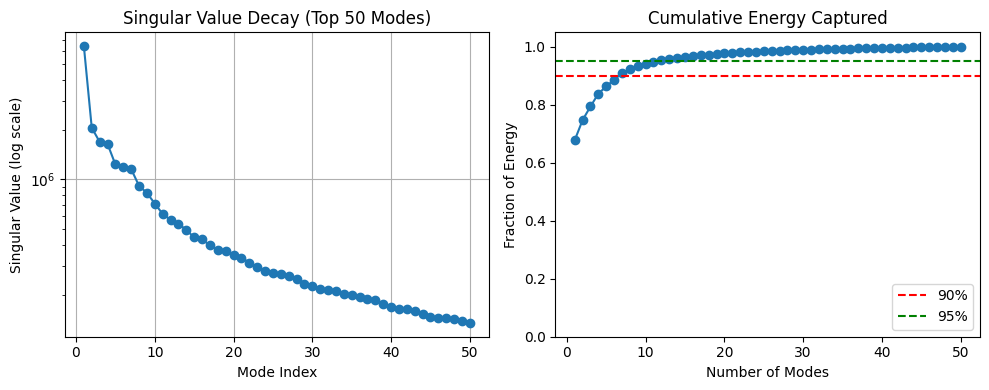

In [5]:
# Display the top 10 singular values for reference
top10_singular_values = S[:10]
print("\nTop 10 singular values:", top10_singular_values.tolist())

# Compute cumulative energy fraction curve
singular_values = S  # (length k)
cumulative_energy = np.cumsum(singular_values**2) / np.sum(singular_values**2)

# Plot singular value decay (log scale) and cumulative energy
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.semilogy(range(1, len(singular_values)+1), singular_values, 'o-')
plt.title('Singular Value Decay (Top {} Modes)'.format(len(singular_values)))
plt.xlabel('Mode Index')
plt.ylabel('Singular Value (log scale)')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, len(singular_values)+1), cumulative_energy, 'o-')
plt.axhline(y=0.9, color='r', linestyle='--', label='90%')
plt.axhline(y=0.95, color='g', linestyle='--', label='95%')
plt.title('Cumulative Energy Captured')
plt.xlabel('Number of Modes')
plt.ylabel('Fraction of Energy')
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


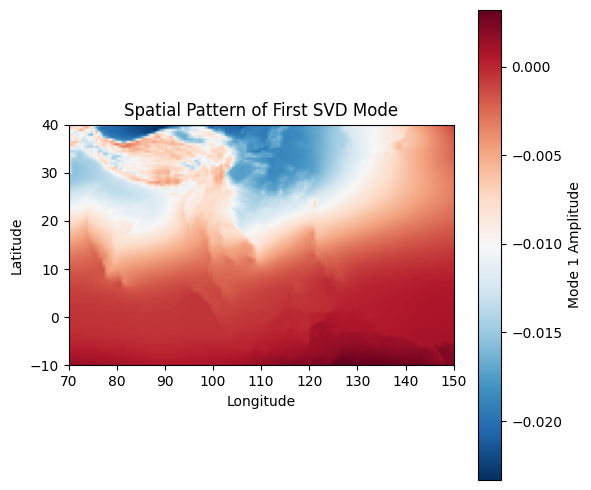

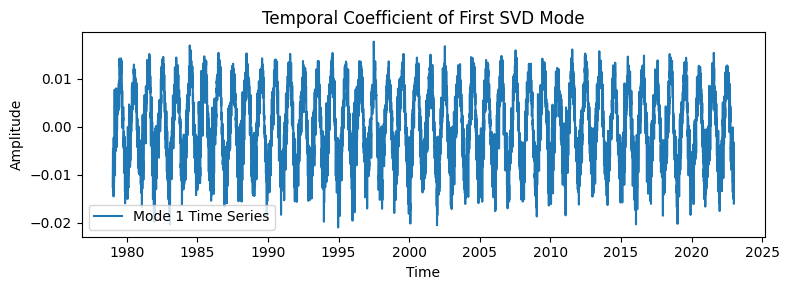

In [6]:
# Prepare the first spatial mode as a map
mode1 = U[:, 0]  # first left singular vector (length = n_space)
mode1_map = mode1.reshape(n_lat, n_lon)  # reshape to lat x lon grid

# If latitude is descending, flip the map for correct orientation in imshow
lat_vals = lats
mode1_map_plot = mode1_map
if lats[0] > lats[-1]:
    mode1_map_plot = np.flipud(mode1_map)
    lat_vals = lat_vals[::-1]

plt.figure(figsize=(6,5))
plt.imshow(mode1_map_plot, cmap='RdBu_r', origin='lower',
           extent=[float(longs.min()), float(longs.max()), float(lat_vals.min()), float(lat_vals.max())])
plt.colorbar(label='Mode 1 Amplitude')
plt.title('Spatial Pattern of First SVD Mode')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

# Plot the first temporal mode (principal component time series)
# The first temporal mode is given by the first row of V^T (or equivalently, U[:,0]*S[0] projected onto time).
time_mode1 = VT[0, :]  # first right singular vector (length = n_time)
plt.figure(figsize=(8,3))
plt.plot(time_values, time_mode1, label='Mode 1 Time Series')
plt.title('Temporal Coefficient of First SVD Mode')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()


In [15]:

# Prepare results dictionary
results = {
        "method": "PyParSVD Serial SVD",
        "k_value": k,
        "runtime": float(elapsed_time),
        "memory_usage": float(peak_mem),
        "reconstruction_error": float(reconstruction_error),
        "noise_robustness": float(noise_error),
        "energy_fraction": float(energy_fraction),
        "top_singular_values": S[:10].tolist()
}

import json
with open("PyParsvd_results.json", "w") as f:
    json.dump(results, f, indent=4)    


    # Print JSON-formatted results
    print(json.dumps(results, indent=4))

{
    "method": "PyParSVD Serial SVD",
    "k_value": 50,
    "runtime": 1292.9346606731415,
    "memory_usage": 19329.37890625,
    "reconstruction_error": 0.0005645768833346665,
    "noise_robustness": 0.0005731481022324145,
    "energy_fraction": 1.0034570693969727,
    "top_singular_values": [
        6421830.5,
        2055495.75,
        1688516.5,
        1640278.125,
        1231180.125,
        1191252.875,
        1154964.625,
        913964.5625,
        827304.1875,
        713049.0
    ]
}
